# Feature Engineering


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix


style.use('fivethirtyeight')

In [2]:
interim_filepath = '../data/interim/'
data = pd.read_csv(f'{interim_filepath}sar_weather_df.csv')

First, though, I need a validation dataset. Since the goal is to predict into the future, we need to take this into account, like was discussed for the bulldozers dataset on Kaggle. I'll use the chronological end of my dataset for validation. If we take everything starting in 2017 and after, that will be ~15% of the total data.

Out test set will be real life - predicting the missions for this upcoming summer.

In [3]:
validate = data[data.Year > 2016]
train = data[data.Year <= 2016]

print(train.shape, validate.shape)

(5461, 35) (820, 35)


In [4]:
print(train.columns)

# remove the date for RF training
train.drop('DATE', axis=1, inplace=True)
validate.drop('DATE', axis=1, inplace=True)

Index(['mission', 'Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
       'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start',
       'Is_year_end', 'Is_year_start', 'Elapsed', 'DATE', 'AWND_x', 'PRCP_x',
       'TAVG_x', 'TMAX_x', 'TMIN_x', 'TSUN', 'WT01', 'WT02', 'WT03', 'WT05',
       'WT08', 'WT10', 'AWND_y', 'PRCP_y', 'SNWD', 'TAVG_y', 'TMAX_y',
       'TMIN_y', 'TOBS', 'WESD'],
      dtype='object')


C:\Users\Abhay\Anaconda3\envs\fastai\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [5]:
y_train = train['mission']
X_train = train.drop('mission', axis=1)

y_validate = validate['mission']
X_validate = validate.drop('mission', axis=1)

In [6]:
m = RandomForestClassifier(n_estimators=100, min_samples_leaf=4, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print(m.score(X_train, y_train))
print(m.score(X_validate, y_validate))
print(m.oob_score_)

0.8590001831166453
0.6792682926829269
0.7233107489470793


**Unbalanced Classes**

The built-in scoring functions probably aren't ideal, since there's only a mission 29% of the time.

ROC curves are a decent approach for scoring our models. These weren't discussed in the fast.ai course, they focused mostly on regression problems. I found [this explination](https://medium.com/greyatom/lets-learn-about-auc-roc-curve-4a94b4d88152) to be helpful. First, I'll calculate precision and recall and compare to a naive model that always predicts the major class (0).

In [7]:
y_score = [x[1] for x in m.predict_proba(X_validate)]

In [8]:
print(roc_auc_score(y_validate,y_score)) # my model
print(roc_auc_score(y_validate, 0.29*np.ones(len(y_validate)))) # naive model


0.6212103047740836
0.5


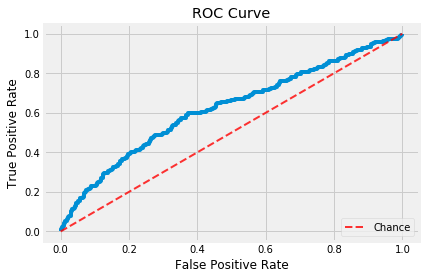

In [9]:
fpr, tpr, thresholds = roc_curve(y_validate, y_score)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

We aren't doing a super great job, but the model is pulling out some useful information beyone the naive model. What does the confusion matrix look like? Need to give the functions actual preductions, not probabilities.

Now, I'll write some functions for repeating these steps.

In [10]:
y_preds = m.predict(X_validate)
pd.crosstab(y_validate, y_preds, rownames=['True'], colnames=['Predicted']).apply(lambda r: 100.0 * r/r.sum())



Predicted,0,1
True,,
0,68.758344,40.84507
1,31.241656,59.15493


We're a little bit better at predicting negative days compared to positive ones.

In [11]:
## Automate the splitting, training and validation

def split_train_val(data):
    validate = data[data.Year > 2016]
    train = data[data.Year <= 2016]

    train.drop('DATE', axis=1, inplace=True)
    validate.drop('DATE', axis=1, inplace=True)
    
    y_train = train['mission']
    X_train = train.drop('mission', axis=1)

    y_validate = validate['mission']
    X_validate = validate.drop('mission', axis=1)
    
    return X_train, y_train, X_validate, y_validate


def build_RF(X_train, y_train):
    m = RandomForestClassifier(n_estimators=100, min_samples_leaf=4, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print('Training Score: ', m.score(X_train, y_train))
    print('OOB Score: ', m.oob_score_)
    return m
    
def test_RF(m, X_validate, y_validate):
    print('Validate Score: ',m.score(X_validate, y_validate))
    y_score = [x[1] for x in m.predict_proba(X_validate)]
    print('ROC AUC: ', roc_auc_score(y_validate,y_score)) # my model
    fpr, tpr, thresholds = roc_curve(y_validate, y_score)

    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    return True

                0           1
count  820.000000  820.000000
mean     0.653069    0.346931
std      0.105605    0.105605
min      0.333443    0.123607
25%      0.585388    0.269797
50%      0.658283    0.341717
75%      0.730203    0.414612
max      0.876393    0.666557


C:\Users\Abhay\Anaconda3\envs\fastai\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


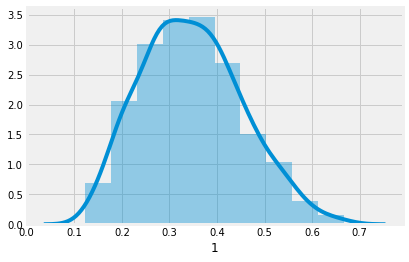

In [12]:
predictions = pd.DataFrame(m.predict_proba(X_validate))
sns.distplot(predictions[1], bins=10) #plot the prediction liklihood of a mission
print(predictions.describe())

Interesting. It's never more than 72% sure that a mission will happen. The negative predictive power is a bit better, getting as low as 11% liklihood. 

## Feature Importances

From what we have so far, what is driving our predictions?

In [13]:
def print_feat_imp(df, m):
    fi = pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)
    print(fi)
    return fi

How can we improve our predictions? Add more features? Holidays? Google Data

## Adding additional features

Let's consider twp ypes of data that are avaliable to add.
- Holiday data
- Google Trends

### Holiday Data

Let's start with the US federal holidays and add them to the dataset as a bool. We also expect that the days surrounding a holiday may see an increase or decrease in missions as well. 

We'll use a list of holidays from pandas

In [14]:
import pandas.tseries.holiday as hol

us_cal = hol.USFederalHolidayCalendar()
dr = pd.date_range(start='2002-01-01', end='2019-05-01')
us_holidays = us_cal.holidays(start=dr.min(), end=dr.max())

In [15]:
# Add column holiday bool to data

data['holiday'] = 0
data['DATE'] =  pd.to_datetime(data['DATE'], infer_datetime_format=True,
                              format='datetime64[ns]')
data['holiday'] = data.DATE.isin(us_holidays)

# Insert the number of days before and after closest holiday

holiday = data.holiday
since = []
d = 0
for i in range(len(holiday)):
    d += 1
    if holiday[i]:
        d = 0   # if it's a holiday, reset
    since.append(d)
#data['holiday_days_since'] = since

before = []
d = 0
for i in range(len(holiday)):
    d += 1
    if holiday[len(holiday) - (i+1)]:
        d = 0   # if it's a holiday, reset
    before.append(d)
#data['holiday_days_before'] = before

data['holiday_closest'] = np.minimum(since, before)

C:\Users\Abhay\Anaconda3\envs\fastai\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Training Score:  0.8610144662149789
OOB Score:  0.7211133492034426
Validate Score:  0.6804878048780488
ROC AUC:  0.6272778132992328


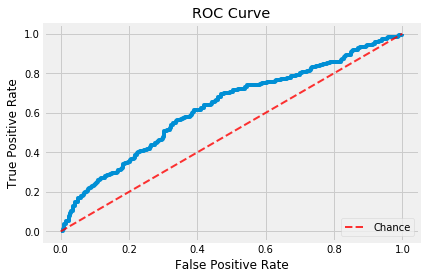

True

In [16]:
# Test it's effect on the model

X_train, y_train, X_validate, y_validate = split_train_val(data)
m = build_RF(X_train, y_train)
test_RF(m, X_validate, y_validate)

In [17]:
print_feat_imp(X_train, m)

                cols       imp
4          Dayofweek  0.085353
12           Elapsed  0.080517
5          Dayofyear  0.063074
13            AWND_x  0.062391
29            TMAX_y  0.060836
16            TMAX_x  0.060632
3                Day  0.059237
34   holiday_closest  0.058609
17            TMIN_x  0.054965
31              TOBS  0.052794
30            TMIN_y  0.051197
28            TAVG_y  0.048757
2               Week  0.041522
0               Year  0.038492
14            PRCP_x  0.034041
32              WESD  0.027463
26            PRCP_y  0.026683
27              SNWD  0.020548
1              Month  0.019376
15            TAVG_x  0.018672
25            AWND_y  0.016874
19              WT01  0.008309
23              WT08  0.003778
33           holiday  0.001805
6       Is_month_end  0.001431
7     Is_month_start  0.000773
9   Is_quarter_start  0.000672
20              WT02  0.000446
8     Is_quarter_end  0.000416
11     Is_year_start  0.000184
10       Is_year_end  0.000090
21      

,cols,imp
4,Dayofweek,0.085353
12,Elapsed,0.080517
5,Dayofyear,0.063074
13,AWND_x,0.062391
29,TMAX_y,0.060836
16,TMAX_x,0.060632
3,Day,0.059237
34,holiday_closest,0.058609
17,TMIN_x,0.054965
31,TOBS,0.052794


After testing different approaches like 'days until next holiday', 'days since last holiday' and 'days from closest holiday', it looks like the 'closest holiday' column without the 'before' and 'since' give the strongest improvement. The is_holiday bool isn't very important on its own.

### Google Trends Data

My hypothesis is that google search trends could give us additional information by acting as a proxy for the number of people actually out on the hiking trails. We can actually get pretty specific data, and the information we're using here is focused on the general 'hiking' topic, however this topic is defined by Google. We can also zoom in on King County, which is where the vast majority of our calls occur.

The data itself was a little bit annoying to get. Google scales the frequency of data output based on how much data you look at. So for example, if I download the entire dataset

In [18]:
raw_filepath = '../data/raw/'

trends = pd.read_csv(f'{raw_filepath}/googletrends_hiking.csv', header=None, names=['date_t', 'trend'])

trends['date_t'] =  pd.to_datetime(trends['date_t'], infer_datetime_format=True,
                              format='datetime64[ns]')

data = pd.merge(data, trends, how='outer', left_on='DATE', right_on='date_t')

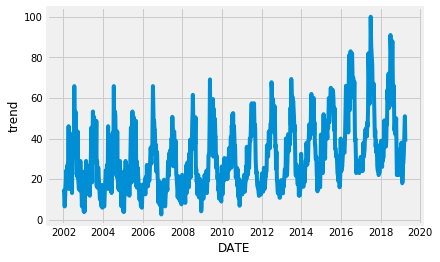

In [19]:
sns.lineplot(data.DATE, data.trend.interpolate())

This fits with my expectations, a seasaonal pattern of interest in hiking, with some variation week-to-week, which may capture information about other events happening in the area that draw people to or from the wilderness.

In [20]:
# Add data to the beginning and end of the dataset through interpolation
data['trend'] = data.trend.interpolate(limit_direction='both')

In [21]:
data.drop('date_t', axis=1, inplace=True)

C:\Users\Abhay\Anaconda3\envs\fastai\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Training Score:  0.8796923640358909
OOB Score:  0.7169016663614722
Validate Score:  0.6841463414634147
ROC AUC:  0.623717897485081


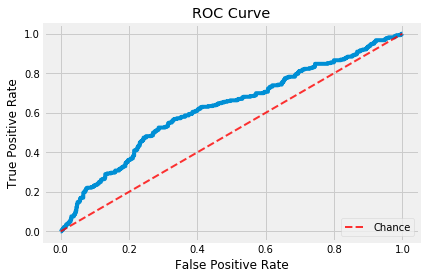

True

In [22]:
# Try a model with this additional data
X_train, y_train, X_validate, y_validate = split_train_val(data)
m = build_RF(X_train, y_train)
test_RF(m, X_validate, y_validate)

In [23]:
fi = print_feat_imp(X_train, m)

                cols       imp
4          Dayofweek  0.083026
35             trend  0.073593
12           Elapsed  0.070797
13            AWND_x  0.060667
5          Dayofyear  0.059150
3                Day  0.057702
16            TMAX_x  0.057023
29            TMAX_y  0.056692
34   holiday_closest  0.051601
17            TMIN_x  0.050958
31              TOBS  0.050795
28            TAVG_y  0.045372
30            TMIN_y  0.044409
2               Week  0.037225
0               Year  0.034107
14            PRCP_x  0.033714
26            PRCP_y  0.024689
32              WESD  0.024655
27              SNWD  0.019544
15            TAVG_x  0.017564
1              Month  0.016625
25            AWND_y  0.016147
19              WT01  0.007026
23              WT08  0.002759
33           holiday  0.001443
7     Is_month_start  0.000907
6       Is_month_end  0.000476
20              WT02  0.000459
9   Is_quarter_start  0.000449
8     Is_quarter_end  0.000257
11     Is_year_start  0.000129
21      

This is very puzzling to me. 'Trend' is clearly an important feature, but it doesn't improve the model by adding it in?

## Feature Importance - Digging In

In [24]:
# Save the data table for now.
data.to_csv(f'{interim_filepath}sar_weather_hol_trend.csv', index=False)

In [25]:
# Make a copy, add std, predictions
x = validate.copy()
x['pred_std'] = np.std(y_score, axis=0)
x['pred'] = y_score

In [26]:
# Predictions based on day of week

dow_summ = x[['Dayofweek', 'mission', 'pred', 'pred_std']].groupby('Dayofweek', as_index=False).mean()
dow_summ

,Dayofweek,mission,pred,pred_std
0,0,0.313559,0.312015,0.105541
1,1,0.230769,0.307568,0.105541
2,2,0.316239,0.305463,0.105541
3,3,0.256410,0.304515,0.105541
4,4,0.264957,0.293669,0.105541
5,5,0.551724,0.455785,0.105541
6,6,0.423729,0.449852,0.105541


C:\Users\Abhay\Anaconda3\envs\fastai\lib\site-packages\scipy\stats\stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


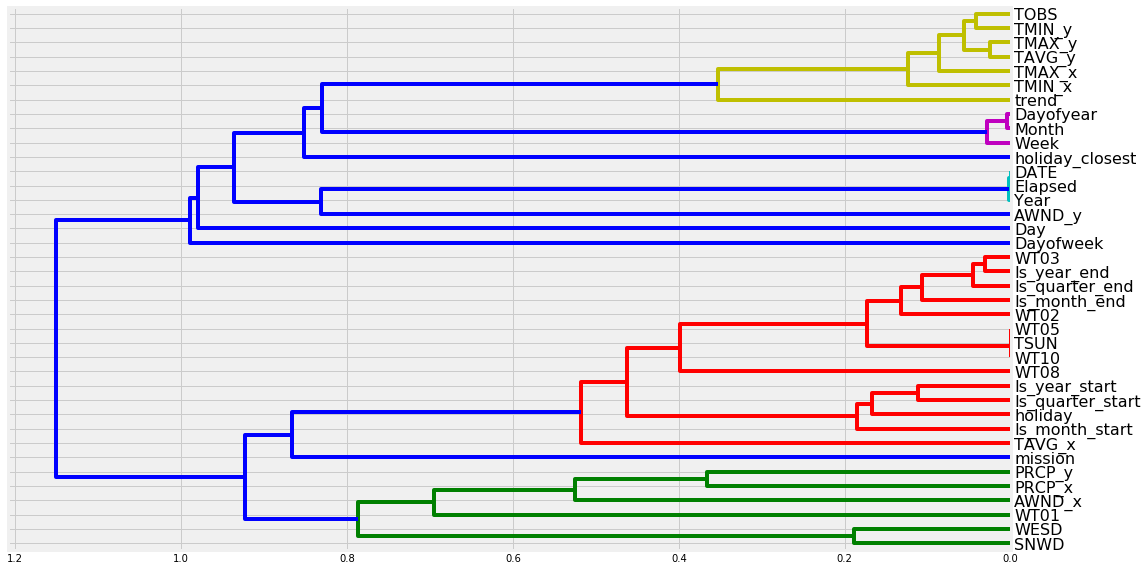

In [27]:
# Clustering Features
import scipy
from scipy.cluster import hierarchy as hc

corr = np.round(scipy.stats.spearmanr(data).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=data.columns, orientation='left', leaf_font_size=16)
plt.show()

In [28]:
# Try removing the least important variables

# First with the baseline model
m = RandomForestClassifier(n_estimators=100, min_samples_leaf=4, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print('Validate Score: ',m.score(X_validate, y_validate))
y_score = [x[1] for x in m.predict_proba(X_validate)]
print('ROC AUC: ', roc_auc_score(y_validate,y_score)) 
fpr, tpr, thresholds = roc_curve(y_validate, y_score)

# Then removing each feature
least_imp = fi[fi.imp < 0.01].cols
for c in least_imp:
    print(c,)
    m = RandomForestClassifier(n_estimators=100, min_samples_leaf=4, n_jobs=-1, oob_score=True)
    m.fit(X_train.drop(c, axis=1), y_train)
    print('Validate Score: ',m.score(X_validate.drop(c, axis=1), y_validate))
    y_score = [x[1] for x in m.predict_proba(X_validate.drop(c, axis=1))]
    print('ROC AUC: ', roc_auc_score(y_validate,y_score)) # my model
    fpr, tpr, thresholds = roc_curve(y_validate, y_score)

Validate Score:  0.6743902439024391
ROC AUC:  0.6271446078431372
WT01
Validate Score:  0.676829268292683
ROC AUC:  0.6348705242966752
WT08
Validate Score:  0.6780487804878049
ROC AUC:  0.6365555733162831
holiday
Validate Score:  0.675609756097561
ROC AUC:  0.644781010230179
Is_month_start
Validate Score:  0.6792682926829269
ROC AUC:  0.6395193947144074
Is_month_end
Validate Score:  0.6865853658536586
ROC AUC:  0.6389799126172209
WT02
Validate Score:  0.6804878048780488
ROC AUC:  0.6293757992327365
Is_quarter_start
Validate Score:  0.6804878048780488
ROC AUC:  0.6235347399829497
Is_quarter_end
Validate Score:  0.6670731707317074
ROC AUC:  0.6350503516624041
Is_year_start
Validate Score:  0.6792682926829269
ROC AUC:  0.6343377024722932
WT03
Validate Score:  0.6817073170731708
ROC AUC:  0.6221560635123615
Is_year_end
Validate Score:  0.6792682926829269
ROC AUC:  0.6402586849957375
WT05
Validate Score:  0.6731707317073171
ROC AUC:  0.6279838022165388
WT10
Validate Score:  0.676829268292683

In [29]:
to_remove =['WT08', 'Is_month_start', 'WT02', 'Is_quarter_start', 'WT05', 'TSUN']
m = RandomForestClassifier(n_estimators=100, min_samples_leaf=4, n_jobs=-1, oob_score=True)
m.fit(X_train.drop(to_remove, axis=1), y_train)
print('Validate Score: ',m.score(X_validate.drop(to_remove, axis=1), y_validate))
y_score = [x[1] for x in m.predict_proba(X_validate.drop(to_remove, axis=1))]
print('ROC AUC: ', roc_auc_score(y_validate,y_score)) # my model
fpr, tpr, thresholds = roc_curve(y_validate, y_score)

Validate Score:  0.6804878048780488
ROC AUC:  0.631220694799659


In [30]:
# Save the data table for now.
data.drop(to_remove, axis=1, inplace=True)
data.to_csv(f'{interim_filepath}sar_final.csv', index=False)

In [31]:
data

,mission,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_quarter_end,Is_year_end,...,PRCP_y,SNWD,TAVG_y,TMAX_y,TMIN_y,TOBS,WESD,holiday,holiday_closest,trend
0,1.0,2002.0,1.0,1.0,1.0,1.0,1.0,False,False,False,...,0.0,0.0,32.0,34.0,30.0,33.0,11.6,True,0.0,13.826509
1,0.0,2002.0,1.0,1.0,2.0,2.0,2.0,False,False,False,...,0.4,0.0,33.0,35.0,30.0,30.0,11.0,False,1.0,13.826509
2,1.0,2002.0,1.0,1.0,3.0,3.0,3.0,False,False,False,...,0.2,0.0,33.0,36.0,30.0,34.0,11.2,False,2.0,13.826509
3,0.0,2002.0,1.0,1.0,4.0,4.0,4.0,False,False,False,...,0.1,0.0,33.0,36.0,31.0,32.0,11.2,False,3.0,13.826509
4,1.0,2002.0,1.0,1.0,5.0,5.0,5.0,False,False,False,...,0.2,0.0,33.0,35.0,32.0,33.0,11.5,False,4.0,13.826509
5,1.0,2002.0,1.0,1.0,6.0,6.0,6.0,False,False,False,...,1.9,0.0,35.0,42.0,31.0,42.0,12.0,False,5.0,13.826509
6,0.0,2002.0,1.0,2.0,7.0,0.0,7.0,False,False,False,...,2.6,0.0,41.0,44.0,38.0,40.0,11.3,False,6.0,13.920567
7,0.0,2002.0,1.0,2.0,8.0,1.0,8.0,False,False,False,...,0.9,0.0,38.0,40.0,35.0,36.0,10.4,False,7.0,14.014624
8,0.0,2002.0,1.0,2.0,9.0,2.0,9.0,False,False,False,...,0.1,0.0,35.0,39.0,33.0,33.0,10.1,False,8.0,14.108682
9,0.0,2002.0,1.0,2.0,10.0,3.0,10.0,False,False,False,...,0.0,0.0,35.0,38.0,33.0,37.0,10.0,False,9.0,14.202740
